# Making Predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

from statsmodels.tsa.ar_model import AutoReg
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

##  Getting all the datasets

In [2]:
# importing the prediction data
df_pred = pd.read_csv('../clean_data/predictions.csv')

# lets rename columns for easy use
df_pred.rename(columns={"Unnamed: 0": "date" , "7dayrollingavg_newlyconfirmed":"7D_roll_pred", 'County':'county'},inplace = True)

# lets reset the index to county
df_pred.set_index('county', inplace= True)

# import data wise california vaccine allocation

df_vacc_alloc = pd.read_csv('../clean_data/vaccine_population.csv')
df_vacc_alloc = df_vacc_alloc[df_vacc_alloc['jurisdiction'] == 'California']
df_vacc_alloc.drop(columns=['2019_population','hhs_region','total_first_allocation' ], inplace = True)

# importing vaccination adminstration  data
df_vacc_admin = pd.read_csv('../clean_data/scrapped_ca_vaccine_ext_feb.csv')
df_vacc_admin.drop(columns=['Unnamed: 5', 'Unnamed: 4'], inplace = True)


# importing county population data
df_county_pop = pd.read_csv('../clean_data/cases_with_mask_use.csv')

# get county and population information only
df_county_pop = pd.DataFrame(df_county_pop.groupby(by = 'county')['population'].max())


##  EDA on county population

In [3]:
df_county_pop.head()

,population
county,
Alameda,1671329
Alpine,1129
Amador,39752
Butte,219186
Calaveras,45905


In [4]:
# Lets create a column that gives the county population ratio to California pop
# of county population to total california population. We will use this for dosage distribution
df_county_pop['ratio_county_pop'] = (df_county_pop['population']/ df_county_pop['population'].sum())
df_county_pop.reset_index(inplace= True)

## EDA on prediction data

In [5]:
# lets look at the data
df_pred.head()
# '2021-02-14'

,date,7D_roll_pred
county,,
Alameda,2020-03-29,1.153915
Alameda,2020-03-30,1.384698
Alameda,2020-03-31,1.478721
Alameda,2020-04-01,1.307770
Alameda,2020-04-02,1.478721


## EDA on vaccination Adminstration data

In [6]:
df_vacc_admin

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959
5,California,2021-01-21,4169450,1532329
6,California,2021-01-22,4379500,1633875
7,California,2021-01-23,4714625,1803679
8,California,2021-01-24,4906525,2008220
9,California,2021-01-25,4906525,2199908


In [7]:
# lets look at the data
df_vacc_admin = df_vacc_admin[df_vacc_admin['state']=='California'][['state' , 'date' ,'total_doses_distributed','total_doses_administered']]
df_vacc_admin["date"]= pd.to_datetime(df_vacc_admin["date"]) 

In [8]:
pd.set_option('display.max_rows', 100)
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959


#### Two steps to be added for this
#### Step 1: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.
#### Step 2: need to split up the data for each county by date.



### Step 1: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.

In [9]:
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959


In [10]:
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959


In [11]:
# lets create new column that is the cumulative 7 days for doses adminstered and doses distributed

df_vacc_admin['doses_dist_7roll'] = 0
df_vacc_admin['doses_admin_7roll'] = 0
for i in range(0,30):
    df_vacc_admin['doses_dist_7roll'][i]= df_vacc_admin['total_doses_distributed'][i+6]- df_vacc_admin['total_doses_distributed'][i]
    df_vacc_admin['doses_admin_7roll'][i]= df_vacc_admin['total_doses_administered'][i+6]- df_vacc_admin['total_doses_administered'][i]
    

In [12]:
# lets remove the dates we dont need i.e any records beyond 2021-02-14
df_vacc_admin = df_vacc_admin[df_vacc_admin['date'] <= '2021-02-14']

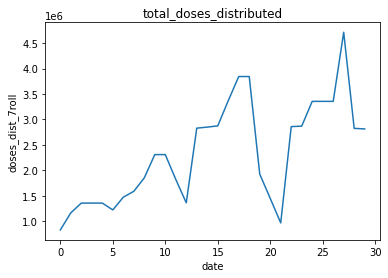

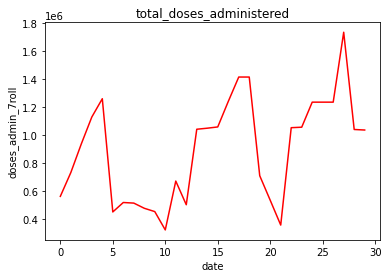

In [13]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['doses_dist_7roll'])
plt.title('total_doses_distributed')
plt.ylabel('doses_dist_7roll');
plt.xlabel('date');
plt.show()

# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['doses_admin_7roll'] , 'r')
plt.title('total_doses_administered')
plt.ylabel('doses_admin_7roll');
plt.xlabel('date');
plt.show()

### Step 2: Need to split the data by county

In [19]:
df_county_pop.head()

,county,population,ratio_county_pop,joinkey
0,Alameda,1671329,0.042299,0
1,Alpine,1129,0.000029,0
2,Amador,39752,0.001006,0
3,Butte,219186,0.005547,0
4,Calaveras,45905,0.001162,0


In [20]:
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered,doses_dist_7roll,doses_admin_7roll,joinkey
0,California,2021-01-16,3548575,1072959,830925,560916,0
1,California,2021-01-17,3548575,1072959,1166050,730720,0
2,California,2021-01-18,3548575,1072959,1357950,935261,0
3,California,2021-01-19,3548575,1072959,1357950,1126949,0
4,California,2021-01-20,3548575,1072959,1357950,1257674,0


In [39]:
# lets do a cross join and merge the data sets for county and county population ratio. 
# this will help us to divide the doses admininstered and doses distributed 7 days cumulative by county

# since we have to do a cross join on two data frames that donot have a Key, lets create a key that is same.
df_county_pop['joinkey'] = 0
df_vacc_admin['joinkey'] = 0

# lets merge the vaccine and county population data together
df_county_vacc_dist_admin_7Droll = pd.merge(df_vacc_admin, df_county_pop, on="joinkey" , how="outer")

# selecting only the columns we need
df_county_vacc_dist_admin_7Droll = df_county_vacc_dist_admin_7Droll[['county' ,'date','doses_dist_7roll','doses_admin_7roll', 
                                                                     'ratio_county_pop', 'population', 'total_doses_administered']]

# rounding the county distribution and adminstration numbers
df_county_vacc_dist_admin_7Droll['doses_dist_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_dist_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])
df_county_vacc_dist_admin_7Droll['doses_admin_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_admin_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])

# selecting only the columns we needed
df_county_vacc_dist_admin_7Droll=df_county_vacc_dist_admin_7Droll[['county', 'date', 'doses_dist_7roll_county' , 
                                                                   'doses_admin_7roll_county', 'population' , 'total_doses_administered']]

In [40]:
# final data set for Vaccine Adminstraion and Distribution by County and Date
df_county_vacc_dist_admin_7Droll.head()

,county,date,doses_dist_7roll_county,doses_admin_7roll_county,population,total_doses_administered
0,Alameda,2021-01-16,35147.0,23726.0,1671329,1072959
1,Alpine,2021-01-16,24.0,16.0,1129,1072959
2,Amador,2021-01-16,836.0,564.0,39752,1072959
3,Butte,2021-01-16,4609.0,3112.0,219186,1072959
4,Calaveras,2021-01-16,965.0,652.0,45905,1072959


### Merge data sets together

#### create a dataframe that has County, Date, Prediction, County population, vaccine allocation

In [41]:
# lets add population to predictions 
df_county_vacc_pred_7Droll  =  pd.merge(df_pred ,df_county_pop, on ='county' , how = 'left' )

# since the 7 day rolling average was based off 100K , we need to calculate actual number of 7 day new patients
df_county_vacc_pred_7Droll['7D_roll_pred_tot'] = np.round((df_county_vacc_pred_7Droll['7D_roll_pred'] * df_county_vacc_pred_7Droll['population'])/ 100_000)

#df_county_vacc_pred_7Droll['7D_roll_pred_tot'] = np.round((df_county_vacc_pred_7Droll['7D_roll_pred'] * 100_000))



# lets look at merged data
df_county_vacc_pred_7Droll = df_county_vacc_pred_7Droll[['county', 'date' ,'7D_roll_pred_tot' ]]

### Append the 'county to population ratio' to merged data set.

In [42]:
df_county_vacc_pred_7Droll["date"]= pd.to_datetime(df_county_vacc_pred_7Droll["date"]) 

In [43]:
df_county_resource = pd.merge(df_county_vacc_pred_7Droll, df_county_vacc_dist_admin_7Droll, on=['county' , 'date'], how="inner")

In [44]:
df_county_resource.head()

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county,population,total_doses_administered
0,Alameda,2021-01-16,923.0,35147.0,23726.0,1671329,1072959
1,Alameda,2021-01-17,895.0,49323.0,30909.0,1671329,1072959
2,Alameda,2021-01-18,856.0,57440.0,39561.0,1671329,1072959
3,Alameda,2021-01-19,827.0,57440.0,47669.0,1671329,1072959
4,Alameda,2021-01-20,745.0,57440.0,53198.0,1671329,1072959


### Calculate the DELTA the difference between predicted new patients and vaccines available

In [45]:
df_county_resource.head()

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county,population,total_doses_administered
0,Alameda,2021-01-16,923.0,35147.0,23726.0,1671329,1072959
1,Alameda,2021-01-17,895.0,49323.0,30909.0,1671329,1072959
2,Alameda,2021-01-18,856.0,57440.0,39561.0,1671329,1072959
3,Alameda,2021-01-19,827.0,57440.0,47669.0,1671329,1072959
4,Alameda,2021-01-20,745.0,57440.0,53198.0,1671329,1072959


In [50]:
df_county_resource['population'].unique().sum()

39508089

In [51]:
df_county_resource['population_percentage'] = df_county_resource['population'] / 39508089

In [60]:
df_county_resource['estimated_doses_administered'] = (df_county_resource['population_percentage'] * df_county_resource['total_doses_administered']).astype(int)

In [66]:
df_county_resource['population_needs_vaccines'] = df_county_resource['population'] - df_county_resource['estimated_doses_administered']

In [67]:
df_county_resource['delta'] = df_county_resource['7D_roll_pred_tot'] - ( df_county_resource['doses_dist_7roll_county'])

In [68]:
df_county_resource['people_per_vaccine'] = round(df_county_resource['population_needs_vaccines']/df_county_resource['doses_admin_7roll_county'], 3)

In [70]:
df_county_resource[df_county_resource['date'] == '2021-02-07'].head()

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county,population,total_doses_administered,delta,people_per_vaccine,population_percentage,estimated_doses_administered,population_needs_vaccines
22,Alameda,2021-02-07,434.0,120963.0,44454.0,1671329,3889904,-120529.0,33.895,0.042303,164556,1506773
52,Amador,2021-02-07,11.0,2877.0,1057.0,39752,3889904,-2866.0,33.906,0.001006,3913,35839
82,Butte,2021-02-07,56.0,15864.0,5830.0,219186,3889904,-15808.0,33.895,0.005548,21580,197606
112,Calaveras,2021-02-07,8.0,3322.0,1221.0,45905,3889904,-3314.0,33.895,0.001162,4519,41386
142,Colusa,2021-02-07,5.0,1559.0,573.0,21547,3889904,-1554.0,33.902,0.000545,2121,19426


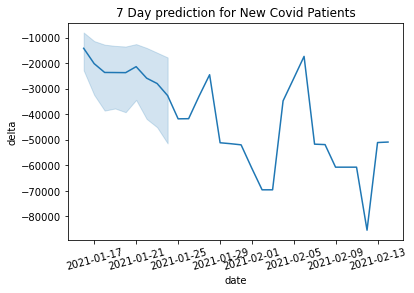

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.lineplot(x="date", y="delta", data=df_county_resource)
plt.xticks(rotation=15)
plt.title('7 Day prediction for New Covid Patients')
plt.show()

In [72]:
# export the data
df_county_resource[df_county_resource['date'] == '2021-02-07'].to_csv('../clean_data/California_2021_02_07.csv', index=False) 